In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

In [2]:
#So the comp training data was a bit dodgy, so there is a bit of a juanky fix which is annoying, here it is

df_train = pd.read_csv("Data/train.csv", index_col="seq_id")
df_train_updates = pd.read_csv("Data/train_updates_20220929.csv", index_col="seq_id")

all_features_nan = df_train_updates.isnull().all("columns")

drop_indices = df_train_updates[all_features_nan].index
df_train = df_train.drop(index=drop_indices)

swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

#Downloading df_test for completeness

df_test =  pd.read_csv("Data/test.csv")

From this point, we should not have any null values in the training data. So now we can start having a little bit of a closer look at the data itself. 

First thing we can do is visualise the data to see how normally distributed it seems to be

<AxesSubplot:xlabel='tm', ylabel='Count'>

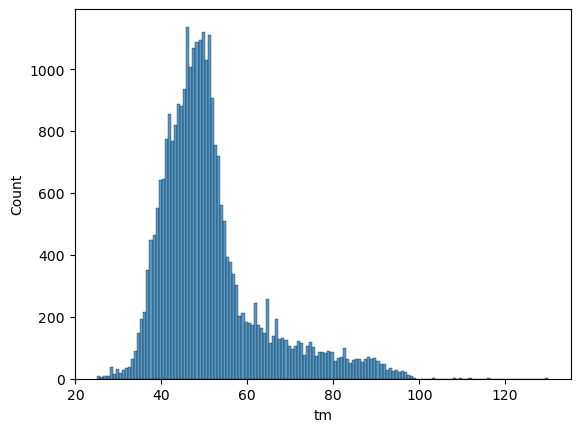

In [17]:
sns.histplot(df_train.tm)

From the above visualisation it does not seem to be particularly normally distributed, with a long tail on the RHS of the data. 

We can try a few transformation to make this better. 

In [18]:
from scipy import stats

fitted_data, fitted_lambda = stats.boxcox(df_train.tm)

<AxesSubplot:ylabel='Count'>

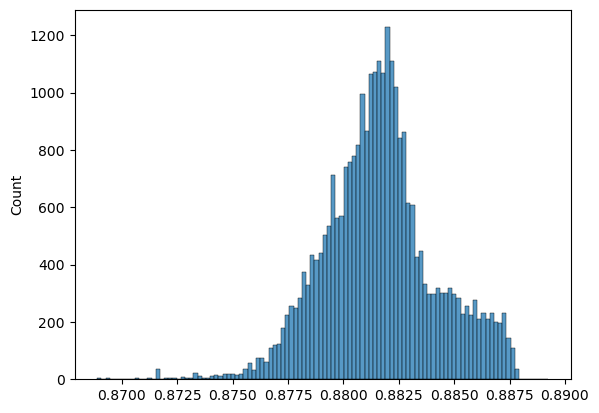

In [19]:
sns.histplot(fitted_data)

This is potentially not the best transformation for the data. 

In [10]:
df_train.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [18]:
df_train.pH.unique()

array([ 7.  ,  7.5 ,   nan,  5.5 ,  6.2 ,  6.3 ,  8.5 ,  3.  ,  6.8 ,
        6.4 ,  6.6 ,  6.7 ,  6.5 ,  4.5 ,  7.3 ,  5.  ,  6.  ,  4.  ,
        3.5 ,  7.4 ,  4.2 ,  5.1 ,  7.1 ,  3.2 ,  2.5 ,  2.  ,  5.2 ,
        7.2 ,  8.  ,  5.8 ,  7.8 ,  9.  ,  7.7 ,  7.6 , 10.  ,  8.2 ,
        2.7 ,  2.8 ,  2.9 ,  3.1 ,  3.14,  2.53,  2.3 ,  2.2 ,  2.81,
        8.25,  9.9 ,  9.5 , 10.4 ,  9.08,  3.7 ,  4.6 ,  4.4 ,  3.6 ,
        5.4 ,  5.35,  5.38,  5.9 ,  5.28,  5.42,  6.1 ,  9.7 ,  8.6 ,
        6.78,  5.3 ,  5.31,  3.02,  6.9 ,  5.7 ,  4.9 ,  4.3 ,  5.45,
        3.01,  3.3 ,  3.8 ,  4.8 ,  2.4 ,  2.84,  2.34,  4.7 ,  2.1 ,
        3.9 ,  2.02,  2.83,  2.03,  2.86,  1.99,  3.16,  2.94,  9.75,
        3.15,  3.07,  3.04,  3.25,  3.21,  2.98,  3.19,  4.1 ,  5.6 ,
        3.75,  4.75,  4.25,  9.6 , 11.  , 10.3 ])

Next thing we want to do is to tokenise the protein_sequence column


In [11]:
list(df_train.iloc[1, 0])

['A',
 'A',
 'A',
 'D',
 'G',
 'E',
 'P',
 'L',
 'H',
 'N',
 'E',
 'E',
 'E',
 'R',
 'A',
 'G',
 'A',
 'G',
 'Q',
 'V',
 'G',
 'R',
 'S',
 'L',
 'P',
 'Q',
 'E',
 'S',
 'E',
 'E',
 'Q',
 'R',
 'T',
 'G',
 'S',
 'R',
 'P',
 'R',
 'R',
 'R',
 'R',
 'D',
 'L',
 'G',
 'S',
 'R',
 'L',
 'Q',
 'A',
 'Q',
 'R',
 'R',
 'A',
 'Q',
 'R',
 'V',
 'A',
 'W',
 'E',
 'D',
 'G',
 'D',
 'E',
 'N',
 'V',
 'G',
 'Q',
 'T',
 'V',
 'I',
 'P',
 'A',
 'Q',
 'E',
 'E',
 'E',
 'G',
 'I',
 'E',
 'K',
 'P',
 'A',
 'E',
 'V',
 'H',
 'P',
 'T',
 'G',
 'K',
 'I',
 'G',
 'A',
 'K',
 'K',
 'L',
 'R',
 'K',
 'L',
 'E',
 'E',
 'K',
 'Q',
 'A',
 'R',
 'K',
 'A',
 'Q',
 'R',
 'E',
 'A',
 'E',
 'E',
 'A',
 'E',
 'R',
 'E',
 'E',
 'R',
 'K',
 'R',
 'L',
 'E',
 'S',
 'Q',
 'R',
 'E',
 'A',
 'E',
 'W',
 'K',
 'K',
 'E',
 'E',
 'E',
 'R',
 'L',
 'R',
 'L',
 'K',
 'E',
 'E',
 'Q',
 'K',
 'E',
 'E',
 'E',
 'E',
 'R',
 'K',
 'A',
 'Q',
 'E',
 'E',
 'Q',
 'A',
 'R',
 'R',
 'E',
 'H',
 'E',
 'E',
 'Y',
 'L',
 'K',
 'L',
 'K',
 'E'